In [17]:
import sys
sys.path.append('../')

In [18]:
import game.agent as ag
from game.run import run
from game.simulator import load_simulator_yarn, GraphSimulator
from pathlib import Path
from tqdm.auto import trange
import pandas as pd
import mpire

In [19]:
n_runs = int(1e3)
seed = None

In [20]:
simulator = load_simulator_yarn('../yarnScripts', graph_file_sfx='_graph_transformed.pickle')

In [21]:
def get_random_agent():
    return ag.RandomAgent(None)

def get_r_agent():
    return ag.LabelDecisorAgent(
        label_predictor=ag.TorchLabelPredictor(
            model_path=Path('../models/tmp/saved_good/adamw_max_val_acc_8_False_125,[20],[20]_0.001'),
            use_cpu=False,
        ),
        decisor=ag.RDecisionMaker(
            rand=0,
            seed=4444,
        )
    )

def get_graph_r_agent():
    return ag.LabelDecisorAgent(
        label_predictor=ag.GraphLabelLoader(
            simulator=simulator,
        ),
        decisor=ag.RDecisionMaker(
            rand=0.2,
            seed=None,
        )
    )

In [22]:
df = run(get_graph_r_agent, simulator, n_runs)

100%|██████████| 1000/1000 [00:01<00:00, 973.44it/s]


In [23]:
print(df)

          title kind
0    MaloAmanda    0
1    MaloAmanda    0
2    MaloAmanda    0
3    MaloAmanda    0
4    MaloAmanda    0
..          ...  ...
995  MaloAmanda    0
996  MaloAmanda    0
997  MaloAmanda    0
998  MaloAmanda    0
999  MaloAmanda    0

[1000 rows x 2 columns]


In [24]:
# df.to_csv('endings.csv')

In [25]:
df['kind'].value_counts(normalize=True)

0    1.0
Name: kind, dtype: float64

<AxesSubplot:>

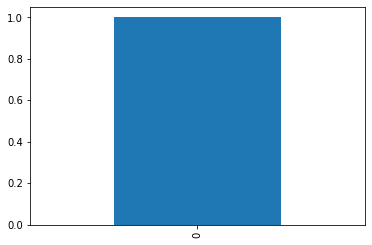

In [26]:
df['kind'].value_counts(normalize=True).plot.bar()

In [27]:
df = run(get_random_agent, simulator, n_runs)

100%|██████████| 1000/1000 [00:00<00:00, 6426.07it/s]


In [28]:
print(df)

             title kind
0     MaloSilencio    0
1       MaloPadres    0
2       MaloPadres    0
3     MaloSilencio    0
4    BuenoSilencio    1
..             ...  ...
995   MaloSilencio    0
996   MaloSilencio    0
997     MaloAmanda    0
998     MaloAmigos    0
999     MaloPadres    0

[1000 rows x 2 columns]


In [29]:
# df.to_csv('endings.csv')

In [30]:
df['kind'].value_counts(normalize=True)

0    0.972
1    0.028
Name: kind, dtype: float64

<AxesSubplot:>

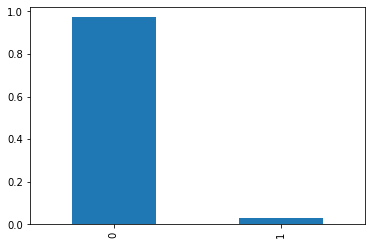

In [31]:
df['kind'].value_counts(normalize=True).plot.bar()

# Multiprocessing (does not work)

In [32]:
# def init_func(worker_state):
#     # Initialize a counter for each worker
#     worker_state['count_even'] = 0
#     pass

# def square_and_count_even(worker_state, x):
#     # Count number of even numbers and return the square
#     if x % 2 == 0:
#         worker_state['count_even'] += 1
#     return x * x
#     pass

# def exit_func(worker_state):
#     # Return the counter
#     return worker_state['count_even']
#     pass

# with mpire.WorkerPool(n_jobs=4, use_worker_state=True, start_method="spawn") as pool:
#     pool.map(square_and_count_even, range(100), worker_init=init_func, worker_exit=exit_func, progress_bar=True)
#     print(pool.get_exit_results())  # Output, e.g.: [13, 13, 12, 12]
#     print(sum(pool.get_exit_results()))  # Output: 50
